In [ ]:
# Downloading/Installing Gensim
# pip install --upgrade gensim

     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     -------------------- ------------------- 30.7/60.4 kB 1.4 MB/s eta 0:00:01
     ---------------------------------------- 60.4/60.4 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/24.0 MB 2.4 MB/s eta 0:00:10
    --------------------------------------- 0.4/24.0 MB 4.8 MB/s eta 0:00:05
    --------------------------------------- 0.5/24.0 MB 4.2 MB/s eta 0:00:06
   - -------------------------------------- 0.8/24.0 MB 4.5 MB/s eta 0:00:06
   - -------------------------------------- 1.0/24.0 MB 4.8 MB/s eta 0:00:05
   - -------------------------------------- 1.1/24.0 MB 4.2 MB/s eta 0:00:06
   -- ------------------------------------- 1.3/24.0 MB 4.5 MB/s eta 0:00:06
   -- ------------------------------------- 1.5/24.0 MB 4.4 MB/s eta 0:00:06
   -- ------------------------------------- 1.7/24.0 MB 4.4 MB/s eta 0:00:06
   --

In [ ]:
# Import necessary libraries
# import gensim.downloader
# word2vec_google = gensim.downloader.load('word2vec-google-news-300')

In [3]:
import pickle

def save_pickle(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

# Part 2

In [8]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import time
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

np.random.seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train = train.drop(['label-fine'], axis=1)
test = test.drop(['label-fine'], axis=1)
display(train)
display(test)

,label-coarse,text
0,0,How did serfdom develop in and then leave Russ...
1,1,What films featured the character Popeye Doyle ?
2,0,How can I find a list of celebrities ' real na...
3,1,What fowl grabs the spotlight after the Chines...
4,2,What is the full form of .com ?
...,...,...
5447,1,What 's the shape of a camel 's spine ?
5448,1,What type of currency is used in China ?
5449,4,What is the temperature today ?
5450,4,What is the temperature for cooking ?


,label-coarse,text
0,4,How far is it from Denver to Aspen ?
1,5,"What county is Modesto , California in ?"
2,3,Who was Galileo ?
3,0,What is an atom ?
4,4,When did Hawaii become a state ?
...,...,...
495,3,Who was the 22nd President of the US ?
496,1,What is the money they use in Zambia ?
497,4,How many feet in a mile ?
498,1,What is the birthstone of October ?


In [10]:
# Print unique labels in train and test dataset
train_labels = train['label-coarse'].sort_values().unique()
test_labels = test['label-coarse'].sort_values().unique()
print(f"Train labels: {train_labels}")
print(f"Test labels: {test_labels}")


Train labels: [0 1 2 3 4 5]
Test labels: [0 1 2 3 4 5]


## Re-classifying classes of original dataset

In [11]:
# Combine labels 2 and 5 to form single class 'OTHERS', denoted by label 2, for train and test dataset
train_mask = ((train['label-coarse']==2) | (train['label-coarse']==5))
test_mask = ((test['label-coarse']==2) | (test['label-coarse']==5))
train.loc[train_mask, 'label-coarse'] = 2
test.loc[test_mask, 'label-coarse'] = 2

display(train)
display(test)

,label-coarse,text
0,0,How did serfdom develop in and then leave Russ...
1,1,What films featured the character Popeye Doyle ?
2,0,How can I find a list of celebrities ' real na...
3,1,What fowl grabs the spotlight after the Chines...
4,2,What is the full form of .com ?
...,...,...
5447,1,What 's the shape of a camel 's spine ?
5448,1,What type of currency is used in China ?
5449,4,What is the temperature today ?
5450,4,What is the temperature for cooking ?


,label-coarse,text
0,4,How far is it from Denver to Aspen ?
1,2,"What county is Modesto , California in ?"
2,3,Who was Galileo ?
3,0,What is an atom ?
4,4,When did Hawaii become a state ?
...,...,...
495,3,Who was the 22nd President of the US ?
496,1,What is the money they use in Zambia ?
497,4,How many feet in a mile ?
498,1,What is the birthstone of October ?


In [12]:
train_labels_cleaned = train['label-coarse'].sort_values().unique()
test_labels_cleaned = test['label-coarse'].sort_values().unique()
print(f"Train labels: {train_labels_cleaned}")
print(f"Test labels: {test_labels_cleaned}")

Train labels: [0 1 2 3 4]
Test labels: [0 1 2 3 4]


In [13]:
from sklearn.model_selection import train_test_split

print("Original train size:", train.shape)

train_set, dev_set = train_test_split(train, test_size = 500)

print("New train size:", train_set.shape)
print("New development set size:", dev_set.shape)
display(train_set)
display(dev_set)

Original train size: (5452, 2)
New train size: (4952, 2)
New development set size: (500, 2)


,label-coarse,text
4943,2,What is Mikhail Gorbachev 's middle initial ?
2346,0,How does the tail affect the flight of a kite ?
1835,2,What were the first three cities to have a pop...
4047,1,What is the movie Jonathan Livingstone Seagull ?
5097,1,What is a fear of home surroundings ?
...,...,...
3772,4,How much Coca Cola is drunk in one day in the ...
5191,2,What cathedral was Thomas Becket murdered in ?
5226,3,What character in The Beverly Hillbillies has ...
5390,2,What does the River Seine empty into ?


,label-coarse,text
3408,2,What city is served by Tempelhol Airport ?
371,1,What is Dudley Do-Right 's horse 's name ?
453,0,What 's nature 's purpose for tornadoes ?
290,0,What is the history of Valentine 's Day cards ?
4457,3,What President became Chief Justice after his ...
...,...,...
472,1,What 's the most commonly-spoken language in B...
691,2,What is the leading pecan and peanut growing s...
3066,3,Name the three races unleashed by the Celestia...
555,2,Where do people mountain climb in Nepal ?


## Neural Network Implementation

### Input Pre-processing
Architecture: Split sentences into words --> Apply word2vec embeddings --> Map embeddings to indices (word indexing) --> Padding --> Convert to PyTorch tensor --> Create DataLoader to load data for model training

In [14]:
# Function to split sentences into words and convert the column into a list of list of words

def split_text_into_words(df, column_name):
   # Split the text into words
   temp_df = df.copy()
   temp_df[column_name] = temp_df[column_name].str.split()

   # Convert the column into a list
   word_list = temp_df[column_name].tolist()

   # Return the list
   return word_list

In [15]:
train_wordList = split_text_into_words(train_set, 'text')
dev_wordList = split_text_into_words(dev_set, 'text')
test_wordList = split_text_into_words(test, 'text')


In [16]:
train_wordList[0]

['What', 'is', 'Mikhail', 'Gorbachev', "'s", 'middle', 'initial', '?']

In [17]:
# Function to convert list of sentences (list of list of words) into a matrix format
def createMatrix(sentences, word2Idx):

    dataset = []

    wordCount = 0
    unknownWordCount = 0

    for sentence in sentences:
        wordIndices = []

        for word in sentence:
            wordCount += 1
            if word in word2Idx:
                wordIdx = word2Idx[word]
            elif word.lower() in word2Idx:
                wordIdx = word2Idx[word.lower()]
            else:
                wordIdx = word2Idx['UNKNOWN_TOKEN']
                unknownWordCount += 1

            # Get the label and map to int
            wordIndices.append(wordIdx)

        dataset.append(wordIndices)

    return dataset

In [18]:
# Finding the longest sentence in the whole dataset (train, dev and test)
train_maxlen = train_set['text'].str.split().str.len().max()
dev_maxlen = dev_set['text'].str.split().str.len().max()
test_maxlen = test['text'].str.split().str.len().max()

print(train_maxlen, dev_maxlen, test_maxlen)

37 31 17


In [19]:
# Function to pad each sentence to a fixed length (max sentence length)
def padding(wordList, max_sentence_length):
    for sentence in wordList:
        num_zeros = max_sentence_length-len(sentence)
        sentence.extend([0]*num_zeros)
    return wordList


In [20]:
# Create label set and word set
labelSet = set()
wordSet = set()

# unique words and labels in data
for dataset in [train_set, test, dev_set]:
    for index, row in dataset.iterrows():
        sentence = row['text']
        label = row['label-coarse']
        labelSet.add(label)
        for word in sentence.split():
            wordSet.add(word.lower())


embed_size = len(word2vec_google.vectors[0])

# Get all words in the word2vec model
w2v_dictionary = list(word2vec_google.key_to_index.keys())

wordEmbeddings = []
# adding vector for padding token
wordEmbeddings.append(np.zeros(embed_size))
# adding vector for unknown vector intialised with uniform distribution
wordEmbeddings.append(np.random.uniform(-0.25, 0.25, embed_size))

# Initialise dictionary to map each word to a unique index
word2Idx = {}

# add padding+unknown
word2Idx["PADDING_TOKEN"] = len(word2Idx)
word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)

# adding vector for words present in the CoNLL2003 dataset
for word in w2v_dictionary:
    try:
        if word.lower() in wordSet:
            embedding_vector = word2vec_google.get_vector(word)
            if embedding_vector is not None:
                wordEmbeddings.append(embedding_vector)
                word2Idx[word] = len(word2Idx)
    except Exception as e:
        pass

wordEmbeddings = np.array(wordEmbeddings)

# format: [[padded wordindices], [caseindices], [padded char indices], [label indices]]

In [21]:
# Converting list of word indices and labels into PyTorch tensors
trainSentences = torch.tensor(padding(createMatrix(train_wordList, word2Idx), train_maxlen))
devSentences = torch.tensor(padding(createMatrix(dev_wordList, word2Idx), train_maxlen))
testSentences = torch.tensor(padding(createMatrix(test_wordList, word2Idx), train_maxlen))

trainLabels = torch.tensor(train_set['label-coarse'].tolist())
devLabels = torch.tensor(dev_set['label-coarse'].tolist())
testLabels = torch.tensor(test['label-coarse'].tolist())

In [22]:
# Create DataLoader for batched model training

from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
   def __init__(self, data, labels):
       self.data = data
       self.labels = labels

   def __len__(self):
       return len(self.data)

   def __getitem__(self, idx):
       return self.data[idx], self.labels[idx]

# Create DataLoader
train_dataloader = DataLoader(CustomDataset(trainSentences, trainLabels), batch_size=64, shuffle=True)
dev_dataloader = DataLoader(CustomDataset(devSentences, devLabels), batch_size=64, shuffle=True)


In [23]:
trainSentences.dtype

torch.int64

In [24]:
# Early stop as regularization to prevent overfitting (stops model training when dev set stops improving)

class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_accuracy = -np.inf

    def early_stop(self, accuracy):
        if accuracy > self.max_accuracy:
            self.max_accuracy = accuracy
            self.counter = 0
        elif accuracy < (self.max_accuracy - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [25]:
wordEmbeddings.shape

(22955, 300)

### BiLSTM Implementation

In [26]:
# Define your Bi-LSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, hidden_size, num_classes,wordEmbeddings,aggregation_method, dropout_rate):
        super(BiLSTMModel, self).__init__()  # Call the superclass's __init__ method

        self.wordEmbeddings = wordEmbeddings
        self.hidden_size = hidden_size
        self.aggregation_method = aggregation_method
        self.dropout_rate = dropout_rate

        self.embedding = nn.Embedding.from_pretrained(embeddings=self.wordEmbeddings,freeze=True,padding_idx=0)
        self.dropout = nn.Dropout(p=self.dropout_rate)

        self.bilstm = nn.LSTM(input_size=self.wordEmbeddings.shape[1], hidden_size=self.hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply by 2 for bidirectional
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = x.to(torch.long)  # Convert the data type of the inputs
        embed_out = self.embedding(x)
        embed_out = embed_out.to(torch.float32)
        lstm_out, _ = self.bilstm(embed_out)

        # Create a mask that is the same size as the input tensor
        mask = (x != 0).float()
        # Apply the mask to the output of the LSTM layer
        lstm_out = lstm_out * mask.unsqueeze(-1)

        if self.aggregation_method == 'avg':
           agg_output = torch.sum(lstm_out, dim=1) / torch.sum(mask, dim=1).unsqueeze(-1)
        elif self.aggregation_method == 'max':
            agg_output = torch.max(lstm_out, dim=1)[0]

        fc_out = self.fc(agg_output)
        softmax_out = self.softmax(fc_out)

        return softmax_out

### Model training

In [33]:
# Creating function for training of machine learning model
def train(model, train_dataloader, dev_dataloader,criterion, optimizer, epochs, early_stopping):

   train_accs = []
   dev_accs = []
   best_model = None
   best_dev_acc = 0

   for epoch in tqdm(range(epochs)):

      model.train()
      correct = 0
      total = 0
      for inputs,labels in train_dataloader:

         # Zero the parameter gradients
         optimizer.zero_grad()

         # Forward pass
         outputs = model(inputs)
         loss = criterion(outputs, labels)

         preds = torch.argmax(outputs,dim=1)

         # Backward pass and optimize
         loss.backward()
         optimizer.step()

         # Calculate accuracy
         correct += torch.sum(preds == labels)
         total += labels.size(0)
      train_accuracy = correct.double()/total
      train_accs.append(train_accuracy)

      model.eval()
      correct = 0
      total = 0
      with torch.no_grad():
         for inputs,labels in dev_dataloader:

            # Forward pass
            outputs = model(inputs)

            preds = torch.argmax(outputs,dim=1)

            # Calculate accuracy
            correct += torch.sum(preds == labels)
            total += labels.size(0)

      dev_accuracy = correct.double()/total
      dev_accs.append(dev_accuracy)

      print(f"Epoch: {epoch+1}, Train Acc: {train_accuracy}, Dev Acc: {dev_accuracy}")

      if dev_accuracy > best_dev_acc:
          best_model = model
          best_dev_acc = dev_accuracy

      if early_stopping.early_stop(dev_accuracy):
          print(f"Early Stopping at Epoch:{epoch+1}")
          break

   print("Best model val_acc:", best_dev_acc)
   return model,train_accs,dev_accs,best_model

In [28]:
import matplotlib.pyplot as plt

def plot_accuracy(train_acc, val_acc):
    f = plt.figure(figsize = (12, 6))
    num_epochs = len(train_acc)
    plt.plot(train_acc, label = "Train Acc")
    plt.plot(val_acc, label = "Val Acc")
    plt.title("Change in Accuracy against Epochs")
    plt.legend()
    plt.xticks(np.arange(0, num_epochs+1, step=1))
    plt.ylabel("Accuracy")
    plt.xlabel("Num epochs")
    plt.show()

### Initialise model

#### Average pooling aggregation method

In [ ]:
avg_pool_blstm = BiLSTMModel(hidden_size=256, num_classes=5, wordEmbeddings=torch.tensor(wordEmbeddings), aggregation_method='avg', dropout_rate=0.5)

early_stopper = EarlyStopper()
loss_fn = nn.CrossEntropyLoss()
lr = 0.001
num_epochs = 50
optimizer = optim.Adam(avg_pool_blstm.parameters(), lr=lr)

In [26]:
start = time.time()
avg_pool_blstm, train_acc,val_acc, best_avg_pool_lstm = train(avg_pool_blstm, train_dataloader, dev_dataloader, criterion=loss_fn, early_stopping=early_stopper, epochs=num_epochs, optimizer=optimizer)
end = time.time()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, Train Acc: 0.41276252019386106, Dev Acc: 0.576
Epoch: 2, Train Acc: 0.6817447495961227, Dev Acc: 0.706
Epoch: 3, Train Acc: 0.7312197092084006, Dev Acc: 0.766
Epoch: 4, Train Acc: 0.7712035541195477, Dev Acc: 0.786
Epoch: 5, Train Acc: 0.8154281098546042, Dev Acc: 0.808
Epoch: 6, Train Acc: 0.835016155088853, Dev Acc: 0.812
Epoch: 7, Train Acc: 0.8596526655896607, Dev Acc: 0.814
Epoch: 8, Train Acc: 0.872778675282714, Dev Acc: 0.82
Epoch: 9, Train Acc: 0.8790387722132472, Dev Acc: 0.812
Epoch: 10, Train Acc: 0.8237075928917609, Dev Acc: 0.764
Epoch: 11, Train Acc: 0.8691437802907916, Dev Acc: 0.844
Epoch: 12, Train Acc: 0.8903473344103393, Dev Acc: 0.834
Epoch: 13, Train Acc: 0.9016558966074314, Dev Acc: 0.846
Epoch: 14, Train Acc: 0.903675282714055, Dev Acc: 0.838
Epoch: 15, Train Acc: 0.9182148626817448, Dev Acc: 0.85
Epoch: 16, Train Acc: 0.9283117932148627, Dev Acc: 0.838
Epoch: 17, Train Acc: 0.9295234248788369, Dev Acc: 0.836
Epoch: 18, Train Acc: 0.9355815831987075, De

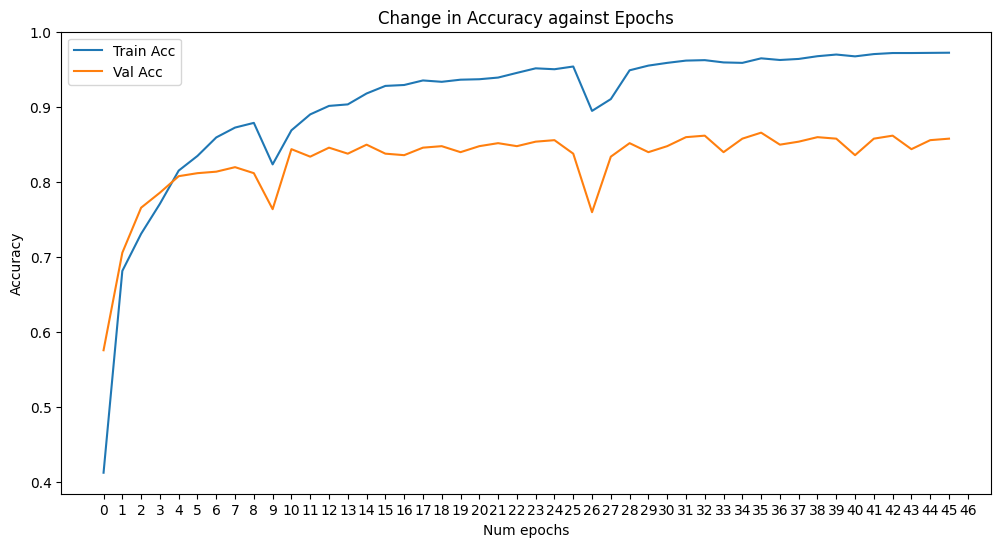

In [32]:
plot_accuracy(train_acc, val_acc)

#### Max pooling aggregation method

In [35]:
max_pool_blstm = BiLSTMModel(hidden_size=256, num_classes=5, wordEmbeddings=torch.tensor(wordEmbeddings), aggregation_method='max', dropout_rate=0.5)

early_stopper = EarlyStopper()
loss_fn = nn.CrossEntropyLoss()
lr = 0.001
num_epochs = 50
optimizer = optim.Adam(max_pool_blstm.parameters(), lr=lr)

In [36]:
start = time.time()
max_pool_blstm, max_train_acc, max_val_acc, best_max_pool_lstm = train(max_pool_blstm, train_dataloader, dev_dataloader, criterion=loss_fn, early_stopping=early_stopper, epochs=num_epochs, optimizer=optimizer)
end = time.time()
print(end-start)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, Train Acc: 0.4432552504038772, Dev Acc: 0.678
Epoch: 2, Train Acc: 0.7191033925686591, Dev Acc: 0.716
Epoch: 3, Train Acc: 0.809168012924071, Dev Acc: 0.81
Epoch: 4, Train Acc: 0.8291599353796446, Dev Acc: 0.804
Epoch: 5, Train Acc: 0.8558158319870759, Dev Acc: 0.826
Epoch: 6, Train Acc: 0.8820678513731826, Dev Acc: 0.834
Epoch: 7, Train Acc: 0.9073101777059773, Dev Acc: 0.844
Epoch: 8, Train Acc: 0.9147819063004846, Dev Acc: 0.836
Epoch: 9, Train Acc: 0.9234652665589661, Dev Acc: 0.86
Epoch: 10, Train Acc: 0.9365912762520194, Dev Acc: 0.866
Epoch: 11, Train Acc: 0.9483037156704361, Dev Acc: 0.876
Epoch: 12, Train Acc: 0.9561793214862682, Dev Acc: 0.88
Epoch: 13, Train Acc: 0.9590064620355412, Dev Acc: 0.878
Epoch: 14, Train Acc: 0.9618336025848142, Dev Acc: 0.878
Epoch: 15, Train Acc: 0.9640549273021002, Dev Acc: 0.88
Epoch: 16, Train Acc: 0.9652665589660743, Dev Acc: 0.876
Epoch: 17, Train Acc: 0.9610258481421647, Dev Acc: 0.884
Epoch: 18, Train Acc: 0.9680936995153473, Dev

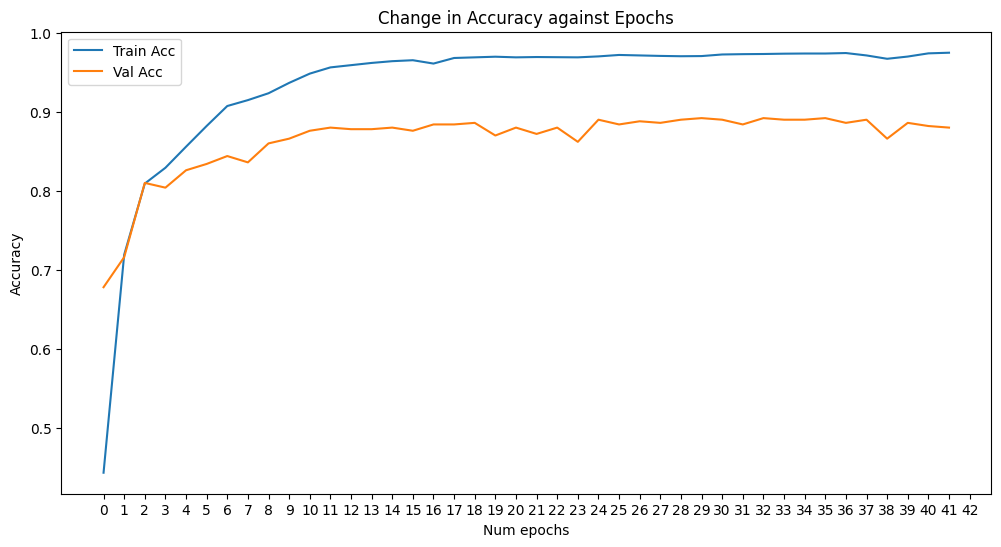

In [37]:
plot_accuracy(max_train_acc, max_val_acc)

### Model evaluation
Perform ML model evaluation by running on test dataset and predicting the labels

In [38]:
test_dataloader = DataLoader(CustomDataset(testSentences, testLabels), batch_size=64, shuffle=True)

In [39]:
def test(model, test_dataloader):
   model.eval()
   correct = 0
   total = 0
   with torch.no_grad():
       for inputs, labels in test_dataloader:
           outputs = model(inputs)
           preds = torch.argmax(outputs, dim=1)
           correct += torch.sum(preds == labels)
           total += labels.size(0)
   test_accuracy = correct.double() / total
   return test_accuracy

In [40]:
test_accuracy = test(best_max_pool_lstm, test_dataloader)
print(f"Test Accuracy for best model (Max Pool BiLSTM): {test_accuracy}")

Test Accuracy for best model (Max Pool BiLSTM): 0.906


### Save best model weights

In [47]:
model_attrs = [
    best_max_pool_lstm.hidden_size,
    best_max_pool_lstm.aggregation_method,
    best_max_pool_lstm.dropout_rate,
    lr,
    optimizer.__class__.__name__
]
model_vers = "_".join([str(i) for i in model_attrs])
model_vers

'256_max_0.5_0.001_Adam'

In [50]:
model_name = f"{model_vers}.pkl"
save_pickle(best_max_pool_lstm, os.path.join(DIR, model_name))
print("Model weights saved.")

Model weights saved.


In [51]:
loaded_model = load_pickle(os.path.join(DIR, model_name))

In [52]:
loaded_model

BiLSTMModel(
  (embedding): Embedding(22955, 300, padding_idx=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (bilstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)